# Exploring some data from the Dataset

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from src.modules.lfw_lightning_data_module import LfwImagesPairsDataset, LFW_DataModule
from src.tools.dataset_tools import get_dataset_filename_map, dataset_download_targz, get_pairs

dataset_download_targz()
image_map = get_dataset_filename_map(min_val=1)
pairs_map = get_pairs()
train_dataset = LfwImagesPairsDataset(image_map,pairs_map["train"])
val_dataset = LfwImagesPairsDataset(image_map,pairs_map["valid"])
test_dataset = LfwImagesPairsDataset(image_map,pairs_map["test"])
print("Number of train pictures", len(train_dataset))
print("Number of valid pictures", len(val_dataset))
print("Number of test pictures", len(test_dataset))

Dataset already downloaded
Number of train pictures 2200
Number of valid pictures 500
Number of test pictures 500


In [3]:
#some of element in image map

c = 0
for key in image_map:
    print(key)
    print(image_map[key],"\n")
    c += 1
    if c==5:
        break
c=0    
for line in pairs_map["valid"]:
    print(line)
    c += 1
    if c==5:
        break

Gregory_Geoffroy
['./data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0001.jpg', './data/dataset/lfw-deepfunneled/Gregory_Geoffroy/Gregory_Geoffroy_0002.jpg'] 

Ellen_Pompeo
['./data/dataset/lfw-deepfunneled/Ellen_Pompeo/Ellen_Pompeo_0001.jpg'] 

Rick_Carlisle
['./data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0004.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0003.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0001.jpg', './data/dataset/lfw-deepfunneled/Rick_Carlisle/Rick_Carlisle_0002.jpg'] 

Ali_Ahmeti
['./data/dataset/lfw-deepfunneled/Ali_Ahmeti/Ali_Ahmeti_0001.jpg'] 

Silvia_Farina_Elia
['./data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0001.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0002.jpg', './data/dataset/lfw-deepfunneled/Silvia_Farina_Elia/Silvia_Farina_Elia_0003.jpg'] 

['Claire_Danes', '1', 'Mitchell_Potter', '1\n']
['Alex_Penelas', '1', '2\n']
['Robert

 Train dataset ----------------------------

 
 



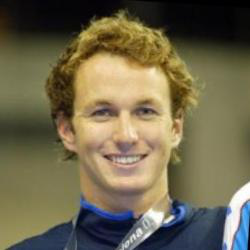

image1


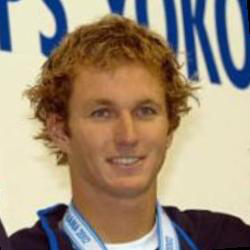

image2
They are the same person?  0.0

 
 



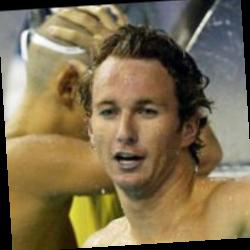

image1


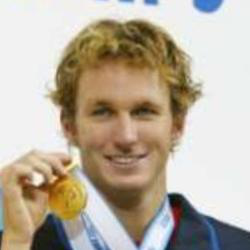

image2
They are the same person?  0.0

 
 



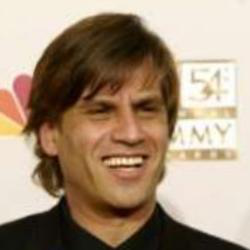

image1


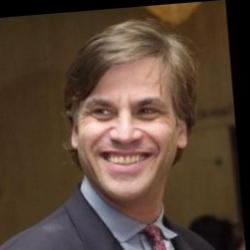

image2
They are the same person?  0.0

 Validation dataset ----------------------------

 
 



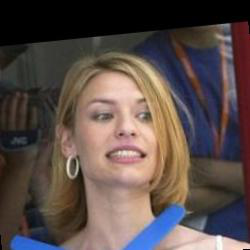

image1


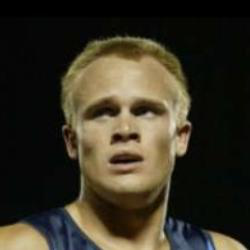

image2
They are the same person?  1.0

 
 



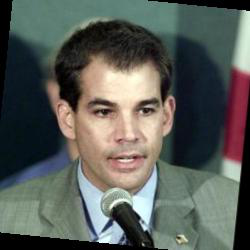

image1


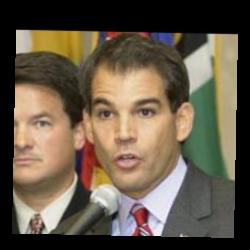

image2
They are the same person?  0.0

 
 



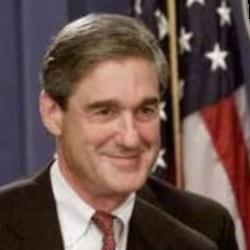

image1


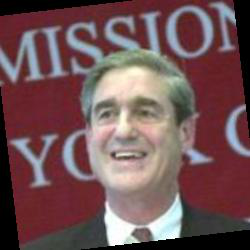

image2
They are the same person?  0.0

 Test dataset ----------------------------

 
 



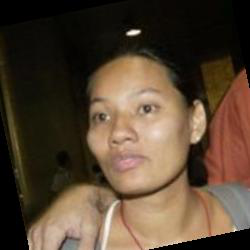

image1


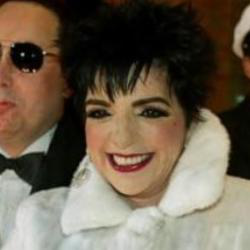

image2
They are the same person?  1.0

 
 



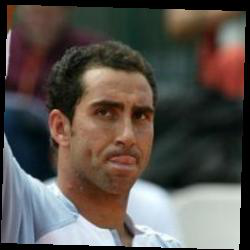

image1


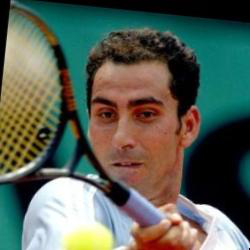

image2
They are the same person?  0.0

 
 



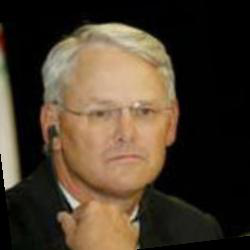

image1


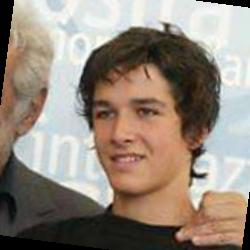

image2
They are the same person?  1.0


In [4]:
#some images

from PIL import Image
import numpy as np

c=0
#image from train dataset
print(" Train dataset ----------------------------")
for image1,image2,label in train_dataset:
    print("\n \n \n")
    display(image1)
    print("image1")
    display(image2)
    print("image2")
    print("They are the same person? ",label)
    c+=1
    if c==3:
        break

#image from validation dataset
c=0
print("\n Validation dataset ----------------------------")
for image1,image2,label in val_dataset:
    print("\n \n \n")
    display(image1)
    print("image1")
    display(image2)
    print("image2")
    print("They are the same person? ",label)
    c+=1
    if c==3:
        break
        
#image from test dataset
c=0
print("\n Test dataset ----------------------------")
for image1,image2,label in test_dataset:
    print("\n \n \n")
    display(image1)
    print("image1")
    display(image2)
    print("image2")
    print("They are the same person? ",label)
    c+=1
    if c==3:
        break

In [5]:
#some statistics
print("Number of subjects: ",len(image_map))
pic=0
for val in image_map.values():
    pic += len(val)
print("Total number of pictures: ",pic)
print("Avg pic for each subject: ", pic/len(image_map))

Number of subjects:  5749
Total number of pictures:  13233
Avg pic for each subject:  2.301791615933206


In [6]:
#DataLoader info
import multiprocessing as mp

dataloader = LFW_DataModule(
    train_dataset, 
    batch_size=32, 
    splitting_points=None, 
    num_workers=mp.cpu_count(), 
    manual_split=True, 
    valid_dataset=val_dataset, 
    test_dataset=test_dataset
)
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Batch_size: ", train_loader.batch_size)
print("Sampler info: ", train_loader.sampler)
print("Train loader length: ",len(train_loader))
print("Validation loader length: ",len(val_loader))
print("Test loader length: ",len(test_loader))

Batch_size:  32
Sampler info:  <torch.utils.data.sampler.RandomSampler object at 0x7f3b9cde0550>
Train loader length:  69
Validation loader length:  16
Test loader length:  16


max value 1.0
min value 0.0
tensor([1., 1., 1., 1., 1.], dtype=torch.float64)


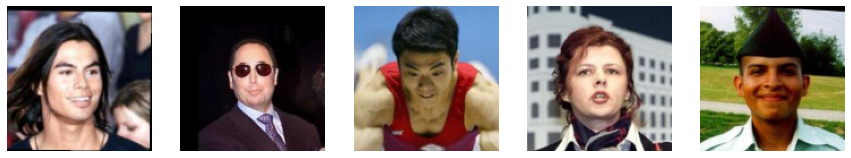

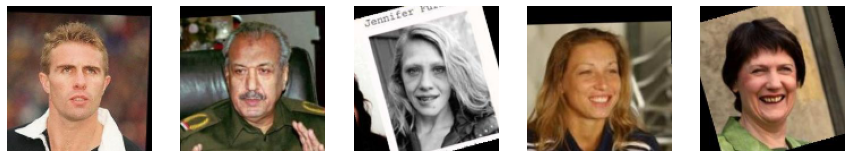

In [7]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

for i, (im1, im2, label) in enumerate(train_loader):
    print('max value', torch.max(im1).item())
    print('min value', torch.min(im1).item())
    visualize_torch(im1[0:5])
    visualize_torch(im2[0:5])
    print(label[0:5])
    
    if i == 0:
        break

# Training the model

## Choosing the model

In [8]:
from src.model.CustomModel import Siamese, CNN_MODEL
import pytorch_lightning as pl
from src.tools.model_tools import ContrastiveLoss
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary

# cnn_model = CNN_MODEL.InceptionResnetV1
cnn_model = CNN_MODEL.MyCNN

if cnn_model == CNN_MODEL.MyCNN:
    model_hparams = {
        "loss_fn": ContrastiveLoss(),
        "lr": 0.001,
        "weight_decay":1e-5,
        "filter_channels": 8,
        "filter_size": 3,
        "dropout": 0.02,
        "n_hidden1": 4096,
        "n_hidden2": 2048,
        "n_hidden3": 128,
        'loss_margin': 5,
    }
    scheduler_params = None
    freeze_layers = False
    
if cnn_model == CNN_MODEL.InceptionResnetV1:
    model_hparams = {
        "loss_fn": nn.BCEWithLogitsLoss(),
        "lr": 0.00001,
        "weight_decay":1e-5,
        "dropout": 0.02,
        "n_hidden1": 1024,
        "n_hidden2": 512,
#         "n_hidden3": 256,
        'loss_margin': 5,
    }
    
#     scheduler_params = {
#         "step_size": 10,
#         "gamma": 0.5,
#     }
    scheduler_params = None
    freeze_layers = True

model = Siamese(hparams=model_hparams, 
                cnn_model = cnn_model, 
                freeze_layers = freeze_layers, 
                scheduler_params = scheduler_params)
model.to('cuda')
print(summary(model,[ (3, model.input_size, model.input_size), (3, model.input_size, model.input_size)]))
model.cpu()

print("Model input size", model.input_size)

Layers to update
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
         MaxPool2d-2            [-1, 8, 64, 64]               0
             PReLU-3            [-1, 8, 64, 64]               1
       BatchNorm2d-4            [-1, 8, 64, 64]              16
     ConvPoolPRelu-5            [-1, 8, 64, 64]               0
            Conv2d-6           [-1, 16, 64, 64]           1,168
         MaxPool2d-7           [-1, 16, 32, 32]               0
             PReLU-8           [-1, 16, 32, 32]               1
       BatchNorm2d-9           [-1, 16, 32, 32]              32
    ConvPoolPRelu-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           4,640
        MaxPool2d-12           [-1, 32, 16, 16]               0
            PReLU-13           [-1, 32, 16, 16]               1
      BatchNorm2d-14  

## Defining the Dataloader

In [9]:
dataloader = LFW_DataModule(
    train_dataset, 
    batch_size=16, 
    splitting_points=None, 
    num_workers=mp.cpu_count(), 
    manual_split=True, 
    valid_dataset=val_dataset, 
    test_dataset=test_dataset,
    input_size=model.input_size
)
dataloader.setup()
train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

In [10]:
# %tensorboard --logdir tb_logs

## Train Custom Model

In [11]:
exp_name = 'resnet_BCE'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    strict=False,
    verbose=False,
    mode='min'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Siamese-Cont-{epoch:02d}-{val_loss:.2f}',
    save_top_k=5,
    mode='min',
)

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": [
        early_stop_callback,
        checkpoint_callback,
    ],
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
    
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger('tb_logs', name=exp_name)

do_train = False

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint/resnet_BCE exists and is not empty. With save_top_k=5, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# Save/Load Checkpoint

## Manual Save

In [12]:
import os

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'saved')  
    checkpoint_path = os.path.join(save_dir, 'Siamese-Contrastive-last.ckpt')
    trainer.save_checkpoint(checkpoint_path)

## Load Checkpoint
Download checkpoints from https://drive.google.com/drive/folders/1puXPrBrquphElXiCDuZSIbSYdRqprxG0?usp=sharing

In [13]:
load_checkpoint = True

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join('data', 'checkpoint', 'margin5', 'Siamese-Contrastive-epoch=25-val_loss=1.00.ckpt')
#     checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Siamese-BCE-epoch=19-val_loss=0.35.ckpt')

    
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
#     x1, x2, label, y = inference(chkpt_model, loader=dataloader.val_dataloader())
#     visualize_torch(x1[:5])
#     visualize_torch(x2[:5])
#     print("labels", label.squeeze()[:5])
#     print("predictions", y.squeeze()[:5])

Layers to update
	 conv.model.0.model.0.weight
	 conv.model.0.model.0.bias
	 conv.model.0.model.2.weight
	 conv.model.0.model.3.weight
	 conv.model.0.model.3.bias
	 conv.model.1.model.0.weight
	 conv.model.1.model.0.bias
	 conv.model.1.model.2.weight
	 conv.model.1.model.3.weight
	 conv.model.1.model.3.bias
	 conv.model.2.model.0.weight
	 conv.model.2.model.0.bias
	 conv.model.2.model.2.weight
	 conv.model.2.model.3.weight
	 conv.model.2.model.3.bias
	 linear.0.model.0.weight
	 linear.0.model.0.bias
	 linear.0.model.1.weight
	 linear.0.model.2.weight
	 linear.0.model.2.bias
	 linear.1.model.0.weight
	 linear.1.model.0.bias
	 linear.1.model.1.weight
	 linear.1.model.2.weight
	 linear.1.model.2.bias
	 linear.2.weight
	 linear.2.bias


## Retrain from checkpoint

In [14]:
resume_training = False
if resume_training:
    checkpoint_path = checkpoint_callback.best_model_path
    trainer = pl.Trainer(**trainer_params, resume_from_checkpoint=checkpoint_path)
    trainer.fit(model)

# Evaluate Model

## Run validation epoch

In [15]:
trainer.test(model, dataloader.val_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_acc': tensor(0.4682), 'avg_loss': tensor(8.8618, dtype=torch.float64)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 8.861759620040857, 'avg_acc': 0.4682116210460663}]

## Run test epoch

In [16]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_acc': tensor(0.4587), 'avg_loss': tensor(8.5836, dtype=torch.float64)}
--------------------------------------------------------------------------------



[{'avg_loss': 8.583625709268517, 'avg_acc': 0.4587288796901703}]

labels tensor([1., 0., 0., 1., 0.], dtype=torch.float64)
predictions tensor([1.1360, 0.8007, 1.3955, 1.5986, 1.2679])


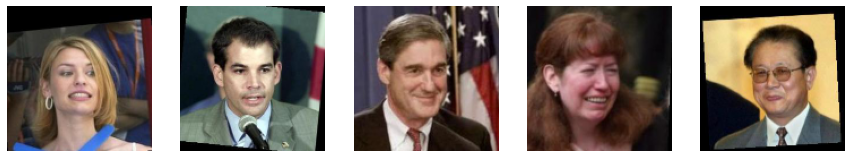

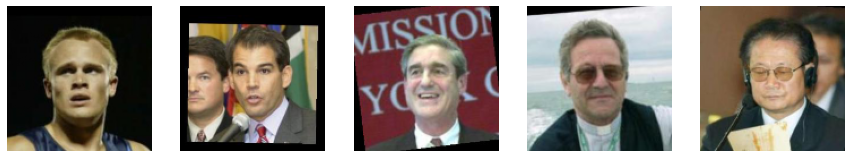

In [17]:
from src.tools.model_tools import inference
from torch.utils import data


for x1, x2, label, y in inference(model, loader=dataloader.val_dataloader()):
    visualize_torch(x1[:5])
    visualize_torch(x2[:5])
    print("labels", label.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break

labels tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.])
predic tensor([0.2362, 1.0635, 0.6285, 0.6720, 1.1251, 0.9396, 0.3531, 0.6816, 1.2737,
        1.2705])


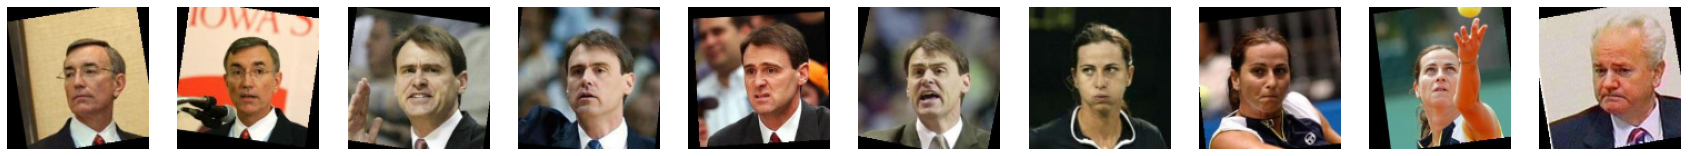

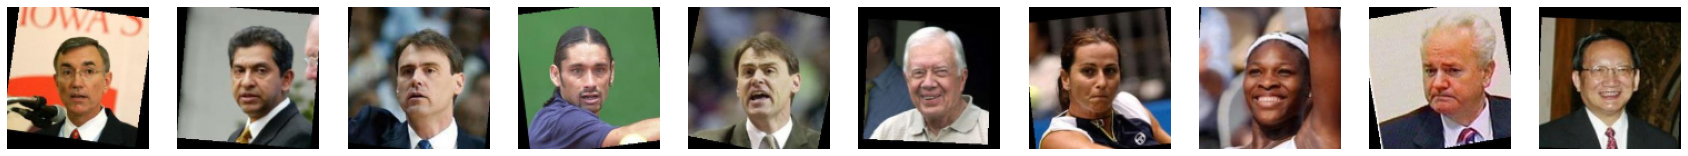

In [18]:
from src.modules.lfw_lightning_data_module import LfwImagesDataset
from torchvision import transforms


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((model.input_size, model.input_size))
        ])
image_map = get_dataset_filename_map()
dataset = LfwImagesDataset(image_map, transform = transform)


inputs=[]
for i, (image1,image2,label) in enumerate(dataset):
    inputs.append((image1,image2,label))
    if i==9:
        break
        
        
for x1, x2, label, y in inference(model, images=inputs):
    visualize_torch(x1[:10], n_cols=10, n_rows = 1)
    visualize_torch(x2[:10], n_cols=10, n_rows = 1)
    print("labels", label.squeeze()[:20])
    print("predic", y.squeeze()[:20])
    break

labels tensor([0., 0., 0., 0., 0.], dtype=torch.float64)
predictions tensor([0.7563, 1.1904, 0.9110, 0.6991, 0.5660])


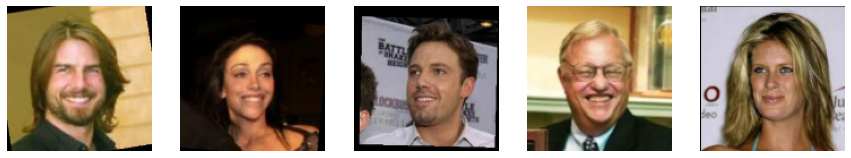

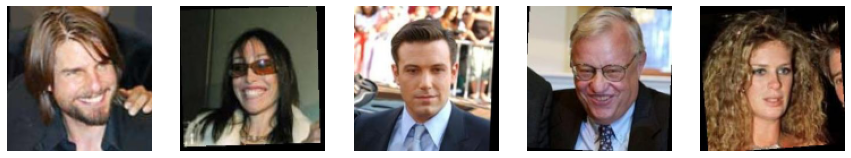

In [19]:
from src.tools.model_tools import inference

imageslist = range(5,10)

for x1, x2, label, y in inference(model, loader=dataloader.test_dataloader()):
    visualize_torch(x1[imageslist])
    visualize_torch(x2[imageslist])
    print("labels", label.squeeze()[imageslist])
    print("predictions", y.squeeze()[imageslist])
    break

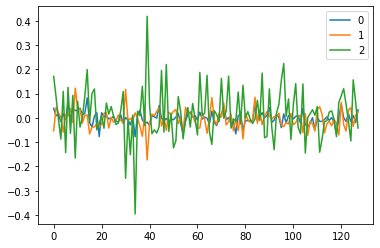

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

data = []
i = 0
for x1, x2, label, y in inference(model, loader=dataloader.test_dataloader()):
  if( label[i] == 0. ):
    data.append( np.asarray( model.forward_one( x1 )[i] ) )
    data.append( np.asarray( model.forward_one( x2 )[i] ) )
    for j in range (1, 2):
      data.append( np.asarray( model.forward_one( x1 )[i + j] ) )
    break
  i += 1

pd.DataFrame(data).T.plot()
plt.show()

In [25]:
from src.modules.lfw_lightning_data_module import LfwImagesDataset
from torchvision import transforms
from src.tools.model_tools import inference_one

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((model.input_size, model.input_size))
        ])
image_map = get_dataset_filename_map()
dataset = LfwImagesDataset(image_map, transform = transform)


inputs=[]
for i, (image1,image2,label) in enumerate(dataset):
    inputs.append((image1,label))
    if i==9:
        break
        
        
for x1, label, embedding in inference_one(model, images=inputs):
#     visualize_torch(x1[:10], n_cols=10, n_rows = 1)

    print("embedding", embedding.shape)
    break

embedding torch.Size([10, 128])
